In [1]:
# Install FiftyOne
!pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download the COCO dataset
# dataset = foz.load_zoo_dataset("coco-2017", split="validation")
# print(dataset)

# Download the COCO training dataset
# dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     split="train",
#     dataset_dir="/content/drive/MyDrive/COCO_dataset/train3",
#     label_types=["detections"],
#     # classes=["person"]
#     max_samples=50,
# )

In [10]:
# Create data class

import os
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image
import torchvision.transforms as T

class CocoCountDataset(Dataset):
    def __init__(self, img_dir, inst_ann_file, caps_ann_file, words, transform=None, max_samples=None):
        self.img_dir = img_dir
        self.coco = COCO(inst_ann_file)
        self.coco_caps = COCO(caps_ann_file)
        self.words=words
        self.transform = transform

        # List downloaded images
        self.downloaded_imgs = self._list_downloaded_images()

        # Filter images based on downloaded images and presence of people
        self.img_ids = self._filter_images()
        self.coco_caps = COCO(caps_ann_file)
        self.words = words

        if max_samples:
            self.img_ids = self.img_ids[:max_samples]

        if not self.img_ids:
            raise ValueError("No valid images found after filtering non-existing files.")

    def _list_downloaded_images(self):
        # List all image files in the directory
        downloaded_imgs = set(os.listdir(self.img_dir))
        return downloaded_imgs

    def _filter_images(self):
        cat_ids = self.coco.getCatIds(catNms=['person'])
        img_ids = self.coco.getImgIds(catIds=cat_ids)

        filtered_img_ids = []
        for img_id in img_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            img_filename = img_info['file_name']
            if img_filename in self.downloaded_imgs:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
                anns = self.coco.loadAnns(ann_ids)
                if any(ann['bbox'] for ann in anns):
                    cap_ids = self.coco_caps.getAnnIds(imgIds=img_id)
                    caps = self.coco_caps.loadAnns(cap_ids)
                    for cap in caps:
                        caption = cap['caption'].lower()
                        if any(word in caption for word in self.words):
                            filtered_img_ids.append(img_id)
                            break

        print(f"Found {len(filtered_img_ids)} images matching criteria.")
        return filtered_img_ids

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.coco.getCatIds(catNms=['person']), iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        count = len(anns)  # Number of people in the image

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)

In [11]:
# Create train and val loader

# Define transformations
transform = T.Compose([
    T.Resize((128, 128)),  # Resize images to 128x128
    T.ToTensor(),
])

# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"
coco_train_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/train3/raw/captions_train2017.json"
coco_val_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/instances_val2017.json"
coco_val_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/captions_val2017.json"

# Directory paths
train_img_dir = '/content/drive/MyDrive/COCO_dataset/train2/train/data'
val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/data'


# # Words to filter in captions
words = ['street', 'road', 'city']

# Create datasets with a limit of xx samples
max_samples = 20

try:
    train_dataset = CocoCountDataset(
        img_dir=train_img_dir,
        inst_ann_file=coco_train_inst_ann_file,
        caps_ann_file=coco_train_caps_ann_file,
        transform=transform,
        words=words,
        max_samples=max_samples
    )
    print(f"Number of training images: {len(train_dataset)}")

    val_dataset = CocoCountDataset(
        img_dir=val_img_dir,
        inst_ann_file=coco_val_inst_ann_file,
        caps_ann_file=coco_val_caps_ann_file,
        transform=transform,
        words=words,
        max_samples=max_samples
    )
    print(f"Number of validation images: {len(val_dataset)}")

except ValueError as e:
    print(e)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

loading annotations into memory...
Done (t=23.66s)
creating index...
index created!
loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
Found 176 images matching criteria.
loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
Number of training images: 20
loading annotations into memory...
Done (t=6.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Found 468 images matching criteria.
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Number of validation images: 20


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define the enhanced CNN model
class EnhancedPeopleCountCNN(nn.Module):
    def __init__(self):
        super(EnhancedPeopleCountCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjust according to the final feature map size
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 8 * 8)  # Adjust the size based on the final feature map size
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x.squeeze()

# Initialize the model, criterion, and optimizer
model = EnhancedPeopleCountCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, counts) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            counts = counts.float()  # Ensure counts are of type float
            loss = criterion(outputs, counts)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=3)

Epoch [1/3], Loss: 1794.3404
Epoch [2/3], Loss: 129.4506
Epoch [3/3], Loss: 51.5045


In [15]:
# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for images, counts in val_loader:
            outputs = model(images)
            loss = criterion(outputs.squeeze(), counts)
            total_loss += loss.item()

    print(f"Validation Loss: {total_loss/len(val_loader):.4f}")

# Evaluate the model
evaluate_model(model, val_loader)

Validation Loss: 14.9787


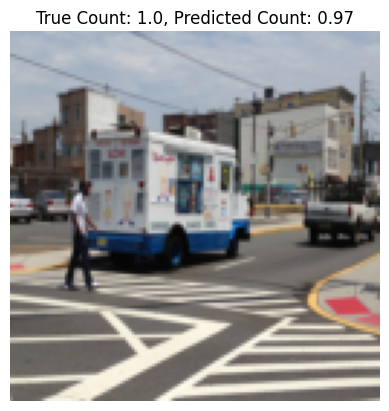

In [17]:
import matplotlib.pyplot as plt

# Function to visualize an image with its predicted count
def visualize_prediction(model, dataset, index=0):
    model.eval()  # Set the model to evaluation mode

    # Get the image and ground truth count from the dataset
    image, true_count = dataset[index]

    # Add a batch dimension and pass the image through the model to get the prediction
    with torch.no_grad():
        image_tensor = image.unsqueeze(0)  # Add batch dimension
        predicted_count = model(image_tensor).item()

    # Convert the image tensor to a numpy array and transpose it to (H, W, C) format
    image_np = image.numpy().transpose(1, 2, 0)

    # Plot the image
    plt.imshow(image_np)
    plt.title(f"True Count: {true_count}, Predicted Count: {predicted_count:.2f}")
    plt.axis('off')
    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(model, val_dataset, index=0)
